In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
print([(f.name, f.fname) for f in fm.fontManager.ttflist if 'D2' in f.name])
plt.rcParams['font.family'] = 'D2Coding'

[('D2Coding', '/home/clim-lab/.local/share/fonts/D2CodingBold-Ver1.3.2-20180524.ttf'), ('D2Coding', '/home/clim-lab/.local/share/fonts/D2Coding-Ver1.3.2-20180524.ttf'), ('D2Coding ligature', '/home/clim-lab/.local/share/fonts/D2CodingBold-Ver1.3.2-20180524-ligature.ttf'), ('D2Coding ligature', '/home/clim-lab/.local/share/fonts/D2Coding-Ver1.3.2-20180524-ligature.ttf')]


In [3]:
# VAR
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [4]:
from utils.transformer_tf import *
import tensorflow as tf

2022-11-14 17:18:07.294718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 17:18:07.488170: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 17:18:08.080122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/clim-lab/miniconda3/envs/MEaI_transformer/lib/
2022-11-14 17:18:08.080216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; d

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-11-14 17:18:08.495043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7781339417160220429
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11279466496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13966726369128755771
 physical_device_desc: "device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:65:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

2022-11-14 17:18:09.073234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 10756 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:65:00.0, compute capability: 6.1


# 날씨 데이터

In [ ]:
PM10 = pd.read_csv('./data/weather_and_pm10.csv')
PM10.일시 = pd.DatetimeIndex(PM10.일시,freq='H')

PM10.index = PM10.일시
PM10 = PM10.drop(columns = ['일시','풍향'])

PM10_col = PM10.columns.copy()
PM10_index = PM10.index.copy()

scaler_pm10 = StandardScaler()
scaler_pm10.fit(PM10)
PM10 = scaler_pm10.transform(PM10)

PM10 = pd.DataFrame(PM10,columns = PM10_col,index=PM10_index)

PM10

## Vector autoregression

In [ ]:
plt.figure(figsize=(15,12))

sns.heatmap(PM10.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [ ]:
PM10_var = PM10[['시정','관악pm10','서울pm10','수원pm10']].copy()

max_diff = 3

fig = plt.figure(figsize=(16,4*max_diff))
ax_list = [fig.add_subplot(max_diff,4,i+1) for i in range(4*max_diff)]

for i in range(max_diff):
    for j,V in enumerate(['시정','관악pm10','서울pm10','수원pm10']):
        if i == 0:
            sm.graphics.tsa.plot_acf(PM10_var[V],lags=24,missing='drop',zero=False, ax=ax_list[4*i+j])
        elif i == 1:
            sm.graphics.tsa.plot_acf(PM10_var[V].diff().dropna(),lags=24,missing='drop',zero=False, ax=ax_list[4*i+j])
        else:
            sm.graphics.tsa.plot_acf(PM10_var[V].diff().diff().dropna(),lags=24,missing='drop',zero=False, ax=ax_list[4*i+j])
        ax_list[4*i+j].set_title(f'{V}, diff_dim={i}')

In [ ]:
data_train = PM10_var[:'2021-12-30 23:00:00'].diff(periods=1).dropna()
data_test = PM10_var['2021-12-30 23:00:00':].diff(periods=1).dropna()
print(data_train.tail())
print('-'*20)
print(data_test.head())

In [ ]:
model = VAR(data_train)

#model.select_order(30)
#results = model.fit(maxlags=30, ic='aic')

results = model.fit(3)
results.summary()

In [ ]:
fig = results.plot_acorr()

In [ ]:
PM10[['서울pm10']][-24:].reset_index(drop=True).to_numpy().reshape(-1)

In [ ]:
data_test.to_numpy()

In [ ]:
lag_order = results.k_ar
fore = results.forecast(data_train.values[-results.k_ar:], 24)
fore = fore[:,-2]

#diff 되돌리기
for i in range(len(fore)):
    past = PM10['서울pm10'].iloc[-25] if i==0 else fore[i-1]
    fore[i] += past

RESULT_pm10 = pd.concat([pd.DataFrame(fore),PM10['서울pm10'][-24:].reset_index(drop=True)],axis=1)
RESULT_pm10.columns = ['forecast(VAR)','Real value']
plt.plot(RESULT_pm10['forecast(VAR)'],color='C0',label='forecast(VAR)')
plt.plot(RESULT_pm10['Real value'],color='Black',label='서울 미세먼지')
plt.legend()

## Basic Transformer

In [ ]:
params = {
    'window_size':30,
    'forecast_range':24,
    'num_layers':6,
    'dff':512,
    'd_model':128,
    'num_heads':8,
    'dropout':0.1
}

In [ ]:
tf.keras.backend.clear_session()
model_pm10 = basic_time_series_transformer(
    window_size=params['window_size'],
    forecast_range=params['forecast_range'],
    num_layers=params['num_layers'],
    dff=params['dff'],
    d_model=params['d_model'], 
    num_heads=params['num_heads'],
    dropout=params['dropout'],
    name="time_series_transformer")

tf.keras.utils.plot_model(model_pm10, to_file='./imgs/basic_transformer.png', show_shapes=True,show_layer_names=True)

In [ ]:
PM10_BT = PM10['서울pm10'].to_numpy()
PM10_BT.shape

In [ ]:
split_by_window = []
label_forecast = []
for i in range(PM10_BT.shape[0]-params['window_size']-params['forecast_range']+1):
    split_by_window.append(PM10_BT[i:i+params['window_size']])
    label_forecast.append(PM10_BT[i+params['window_size']-1:i+params['window_size']+params['forecast_range']])
split_by_window = np.array(split_by_window)
label_forecast = np.array(label_forecast)
print(split_by_window.shape,label_forecast.shape)

In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.

split_point=round(label_forecast.shape[0]*0.8)
print(split_point)

BATCH_SIZE = 512
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': split_by_window[:split_point],
        'dec_inputs': label_forecast[:split_point,:-1] #teaching force
    },
    {
        'outputs': label_forecast[:split_point, 1:,np.newaxis]
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': split_by_window[split_point:],
        'dec_inputs': label_forecast[split_point:,:-1] #teaching force
    },
    {
        'outputs': label_forecast[split_point:, 1:,np.newaxis]  
    },
))

test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
model_pm10.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError()
)

callback_path = './result/basic_transformer/PM10'

os.makedirs(f'{callback_path}/ckpt', exist_ok=True)
ckpt_path = callback_path+'/ckpt/model_ckpt'
callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor='val_loss',
    save_best_only = True,
    save_weights_only=True,
    verbose=1
)

os.makedirs(f'{callback_path}/tsbd', exist_ok=True)
callback_tsbd = tf.keras.callbacks.TensorBoard(f'{callback_path}/tsbd')

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.95 # 5epoch 이후 0.95씩 줄어듦(ex. 0.001, 0.001*0.95, 0.001*0.95^2, 0.001*0.95^3, ...)
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
lr = 0.001
e = np.arange(40)

r = [lr for _ in range(len(e))]
for i in range(40):
    lr_ = lr if i == 0 else r[i-1]
    lr_ = scheduler(i, lr_)
    r[i] = lr_

print(r)
plt.plot(e,r)


In [ ]:
history = model_pm10.fit(train_dataset, epochs=20, validation_data=test_dataset, verbose = 1, callbacks=[callback_ckpt,callback_scheduler,callback_tsbd])

In [ ]:
model_pm10.load_weights('./result/basic_transformer/PM10/ckpt/model_ckpt')

In [ ]:
data_test = PM10['서울pm10'].to_numpy()[np.newaxis,-(params['window_size']+params['forecast_range']):-params['forecast_range']]
data_test_dec_input = data_test[0,-1].reshape((1,1))
data_test, data_test_dec_input

In [ ]:
out = model_pm10.predict([data_test,data_test_dec_input])
np.concatenate([data_test_dec_input,out.reshape((1,-1))],axis=1)

In [ ]:
out = model_pm10.predict([data_test,data_test_dec_input])
out_ = np.concatenate([data_test_dec_input,out.reshape((1,-1))],axis=1)

for i in range(23):
    out = model_pm10.predict([data_test,out_])
    out_ = np.concatenate([data_test_dec_input,out.reshape((1,-1))],axis=1)

print(out)
print(out.shape)

In [ ]:
RESULT_pm10_2 = pd.concat([pd.DataFrame(out[0,:,:]),RESULT_pm10],axis=1)
RESULT_pm10_2.columns = ['forecast(Basic Transformer)','forecast(VAR)','Real value']

RESULT_pm10_2 = RESULT_pm10_2*np.sqrt(scaler_pm10.var_[-2])+scaler_pm10.mean_[-2] #scale 되돌림

RESULT_pm10_2.to_csv('./비교모델 결과(미세먼지).csv',index=False)

In [ ]:
plt.plot(RESULT_pm10_2['forecast(Basic Transformer)'],color='C1',label='forecast(Basic Transformer)')
plt.plot(RESULT_pm10_2['forecast(VAR)'],color='C0',label='forecast(VAR)')
plt.plot(RESULT_pm10_2['Real value'],color='Black',label='서울 미세먼지')
plt.title('서울 미세먼지 예측(비교 모델)')
plt.legend()

# KOSPI 데이터

In [35]:
KOSPI = pd.read_csv('./data/kospi_financeIndex_and_stock.csv')
KOSPI.Date = pd.DatetimeIndex(KOSPI.Date)

KOSPI.index = KOSPI.Date
KOSPI = KOSPI.drop(columns = ['Date'])

KOSPI_col = KOSPI.columns.copy()
KOSPI_index = KOSPI.index.copy()

scaler_kospi = StandardScaler()
scaler_kospi.fit(KOSPI)
KOSPI = scaler_kospi.transform(KOSPI)

KOSPI = pd.DataFrame(KOSPI,columns = KOSPI_col,index=KOSPI_index)

KOSPI

,KOSPI,KQ11,USD/KRW,JPY/KRW,US500,IXIC,DGS10,POILDUBUSDM,인디에프_close,대한전선_close,...,금호석유_close,평화산업_close,대호에이엘_close,고려산업_close,GKL_close,씨아이테크_close,와이투솔루션_close,KT&G_close,롯데케미칼_close,대우부품_close
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-1.074499,-0.628396,0.686106,-1.883796,-1.305567,-1.148805,0.456163,-2.186352,1.156618,1.011598,...,-1.008772,-0.046487,-1.078050,-1.169622,0.508546,1.491176,-0.936367,0.461748,-0.683580,-1.561462
2016-01-05,-1.044779,-0.581656,1.009231,-1.114412,-1.299943,-1.152484,0.470515,-2.186352,1.518429,1.065622,...,-1.010689,-0.037440,-1.092536,-1.161045,0.611873,1.396294,-0.931328,0.498879,-0.609084,-1.619897
2016-01-06,-1.057657,-0.557840,1.042397,-1.026605,-1.336675,-1.170052,0.370050,-2.186352,1.462148,1.011598,...,-0.995354,-0.057794,-1.086742,-1.139604,0.446550,1.396294,-0.892099,0.573141,-0.460093,-1.594854
2016-01-07,-1.110935,-0.614478,1.286754,-0.764460,-1.402183,-1.216228,0.341345,-2.186352,1.413906,0.998803,...,-1.016440,-0.209317,-1.125852,-1.169622,0.312225,1.252867,-0.920531,0.387485,-0.556937,-1.644941
2016-01-08,-1.077377,-0.592895,1.205058,-0.630191,-1.431430,-1.230680,0.298289,-2.186352,1.140538,0.917767,...,-0.999187,-0.209317,-1.148305,-1.199639,0.322558,1.016765,-0.931328,0.610273,-0.393047,-1.644941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,1.687053,1.824926,0.963872,-0.239853,2.462297,2.243570,-0.605902,1.239557,-1.231334,0.388901,...,1.525382,0.380943,0.565325,-0.406317,-1.599321,0.286392,-1.051537,-1.082910,-0.929416,0.467095
2021-12-27,1.654531,1.854250,0.974116,-0.225895,2.553121,2.312327,-0.634606,1.239557,-1.199173,0.383214,...,1.554136,0.347020,0.558082,-0.376299,-1.619986,0.087801,-1.051537,-1.082910,-0.914517,0.391964
2021-12-28,1.706774,1.973928,0.967531,-0.288495,2.546400,2.284072,-0.620254,1.239557,-1.239374,0.403118,...,1.534967,0.132174,0.521868,-0.406317,-1.588988,0.087801,-1.051537,-1.105189,-0.921966,0.291788


In [36]:
close_stock = KOSPI.iloc[:,8:].copy()
close_stock = pd.concat([KOSPI['KOSPI'],close_stock],axis=1)
corr_name = close_stock.corr().sort_values(by='KOSPI',ascending=False).index.to_list()

select_range = 20
select_by_corr = []
select_by_corr.extend(corr_name[1:select_range+1])
select_by_corr.extend(corr_name[-select_range:])

close_stock.corr().sort_values(by='KOSPI',ascending=False)['KOSPI'][select_by_corr]

LG전자_close       0.962965
금호석유_close       0.911382
현대차_close        0.903168
삼성전자우_close      0.898694
그린케미칼_close      0.897949
삼성전자_close       0.891212
영풍제지_close       0.887851
한온시스템_close      0.873761
서울식품_close       0.865326
카카오_close        0.864398
SK이노베이션_close    0.856599
포스코케미칼_close     0.854647
대한항공_close       0.854641
LG이노텍_close      0.851709
KEC_close        0.851396
NAVER_close      0.849930
한화솔루션_close      0.849688
DB하이텍_close      0.839805
다올투자증권_close     0.833602
대창_close         0.829901
제이준코스메틱_close   -0.301301
와이투솔루션_close    -0.312368
태평양물산_close     -0.326819
GKL_close       -0.332774
한국항공우주_close    -0.354151
세원이앤씨_close     -0.367620
KG스틸_close      -0.392332
STX_close       -0.395044
흥아해운_close      -0.397465
에이프로젠제약_close   -0.402418
한국전력_close      -0.425078
강원랜드_close      -0.427269
KR모터스_close     -0.467246
쌍방울_close       -0.478882
마니커_close       -0.480190
KT&G_close      -0.490517
인디에프_close      -0.505008
한창_close        -0.538270
베트남개발1_close

## Vector autoregression

In [9]:
select_col = select_by_corr
select_col.extend(KOSPI.columns[:8].to_list())
KOSPI_var = KOSPI[select_col].copy()
KOSPI_var

,LG전자_close,금호석유_close,현대차_close,삼성전자우_close,그린케미칼_close,삼성전자_close,영풍제지_close,한온시스템_close,서울식품_close,카카오_close,...,베트남개발1_close,다이나믹디자인_close,KOSPI,KQ11,USD/KRW,JPY/KRW,US500,IXIC,DGS10,POILDUBUSDM
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-1.003671,-1.008772,-0.209728,-1.428262,-0.478895,-1.673115,-0.564021,-0.646383,-0.806400,-0.558942,...,1.158000,1.627677,-1.074499,-0.628396,0.686106,-1.883796,-1.305567,-1.148805,0.456163,-2.186352
2016-01-05,-0.947906,-1.010689,-0.222922,-1.420618,-0.497562,-1.669367,-0.560883,-0.697047,-0.793575,-0.549598,...,1.354445,1.575549,-1.044779,-0.581656,1.009231,-1.114412,-1.299943,-1.152484,0.470515,-2.186352
2016-01-06,-0.935514,-0.995354,-0.315279,-1.433358,-0.518939,-1.710597,-0.629907,-0.688603,-0.832051,-0.539193,...,1.256222,1.570949,-1.057657,-0.557840,1.042397,-1.026605,-1.336675,-1.170052,0.370050,-2.186352
2016-01-07,-0.926220,-1.016440,-0.381249,-1.466483,-0.509003,-1.725589,-0.698931,-0.781485,-0.857701,-0.548537,...,1.256222,1.570949,-1.110935,-0.614478,1.286754,-0.764460,-1.402183,-1.216228,0.341345,-2.186352
2016-01-08,-0.898337,-0.999187,-0.407637,-1.456291,-0.509003,-1.715594,-0.686381,-0.899699,-0.870526,-0.559459,...,1.207111,1.561686,-1.077377,-0.592895,1.205058,-0.630191,-1.431430,-1.230680,0.298289,-2.186352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,1.598690,1.525382,1.676998,1.889351,1.287547,1.850175,2.074573,0.831294,1.373876,1.805682,...,-1.297565,-1.861798,1.687053,1.824926,0.963872,-0.239853,2.462297,2.243570,-0.605902,1.239557
2021-12-27,1.645160,1.554136,1.624222,1.863870,1.275503,1.831434,2.080848,0.789075,1.348226,1.766857,...,-1.248454,-1.882432,1.654531,1.854250,0.974116,-0.225895,2.553121,2.312327,-0.634606,1.239557
2021-12-28,1.645160,1.534967,1.637416,1.863870,1.269482,1.837681,2.124772,0.831294,1.373876,1.779799,...,-1.248454,-1.880515,1.706774,1.973928,0.967531,-0.288495,2.546400,2.284072,-0.620254,1.239557


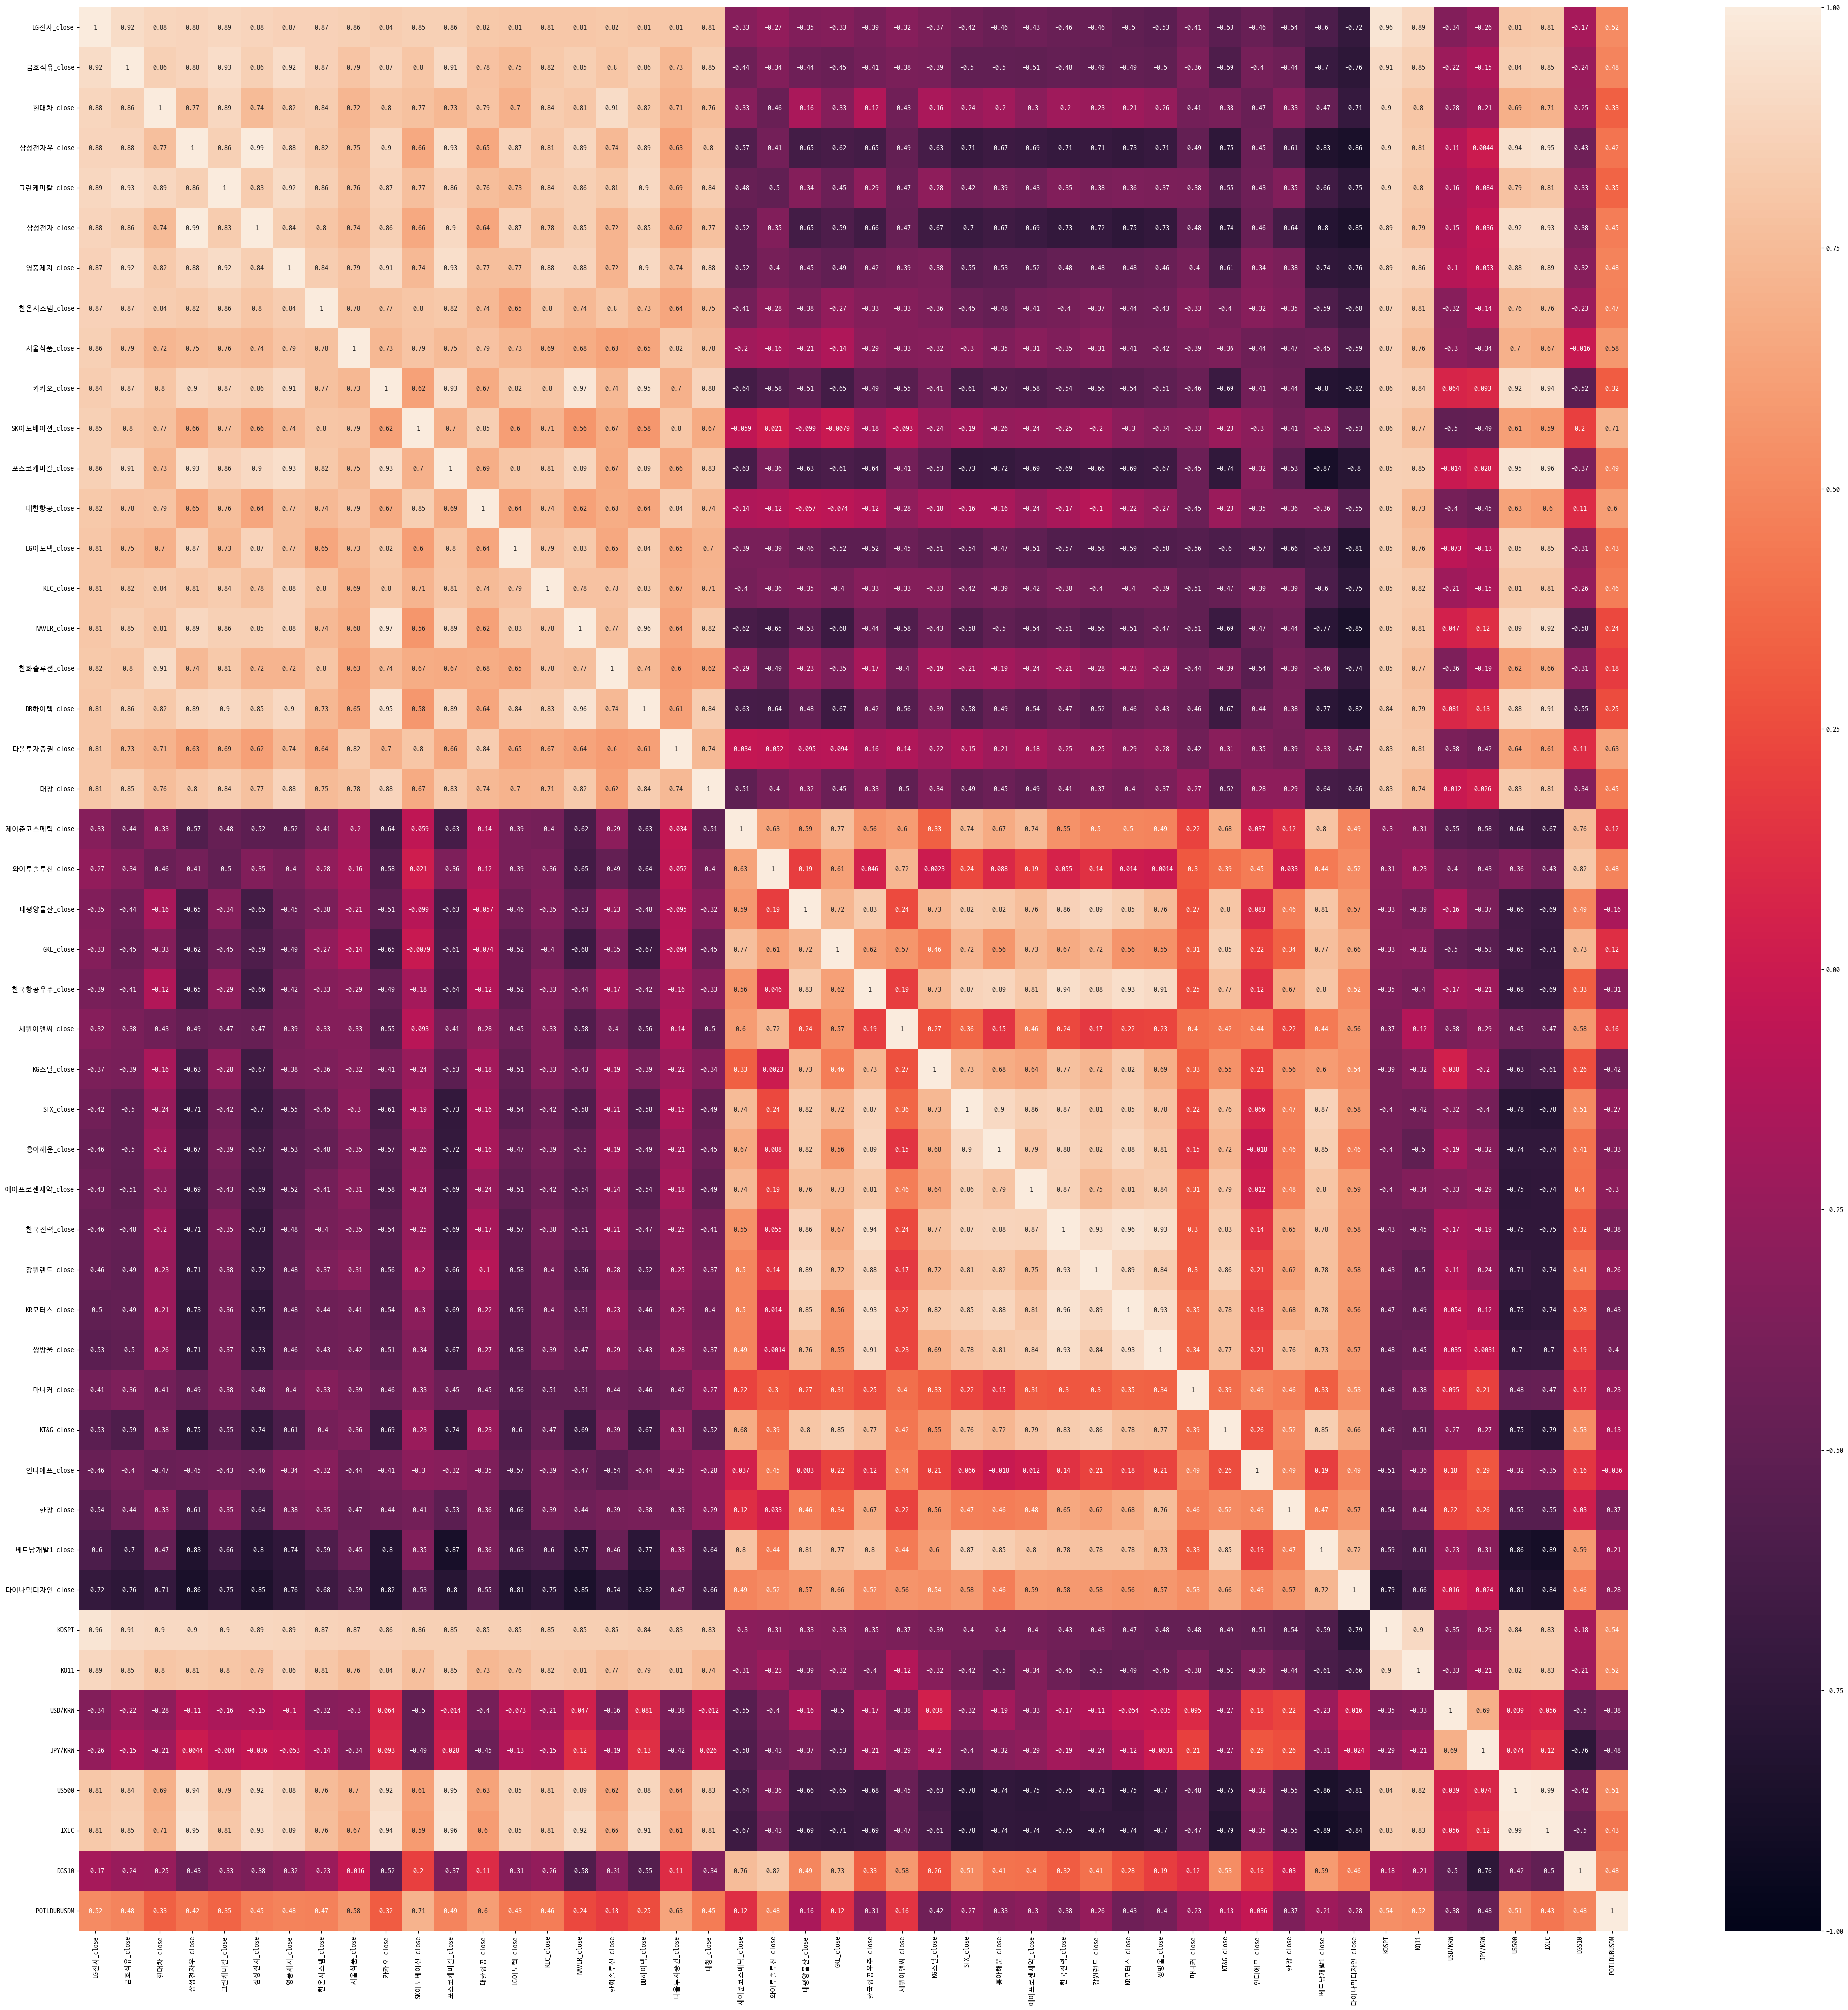

In [10]:
plt.figure(figsize=(50,50))

sns.heatmap(KOSPI_var.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [11]:
select_col =  KOSPI_var.corr()[abs(KOSPI_var.corr()['KOSPI']) > 0.7].KOSPI.index.to_list()
print(KOSPI_var.corr()[abs(KOSPI_var.corr()['KOSPI']) > 0.7].KOSPI)
print(len(select_col))

KOSPI_var_1 = KOSPI_var[select_col].copy()
KOSPI_var_1.reset_index(drop=True,inplace=True)
KOSPI_var_1

LG전자_close       0.962965
금호석유_close       0.911382
현대차_close        0.903168
삼성전자우_close      0.898694
그린케미칼_close      0.897949
삼성전자_close       0.891212
영풍제지_close       0.887851
한온시스템_close      0.873761
서울식품_close       0.865326
카카오_close        0.864398
SK이노베이션_close    0.856599
포스코케미칼_close     0.854647
대한항공_close       0.854641
LG이노텍_close      0.851709
KEC_close        0.851396
NAVER_close      0.849930
한화솔루션_close      0.849688
DB하이텍_close      0.839805
다올투자증권_close     0.833602
대창_close         0.829901
다이나믹디자인_close   -0.785547
KOSPI            1.000000
KQ11             0.903566
US500            0.835250
IXIC             0.832010
Name: KOSPI, dtype: float64
25


,LG전자_close,금호석유_close,현대차_close,삼성전자우_close,그린케미칼_close,삼성전자_close,영풍제지_close,한온시스템_close,서울식품_close,카카오_close,...,NAVER_close,한화솔루션_close,DB하이텍_close,다올투자증권_close,대창_close,다이나믹디자인_close,KOSPI,KQ11,US500,IXIC
0,-1.003671,-1.008772,-0.209728,-1.428262,-0.478895,-1.673115,-0.564021,-0.646383,-0.806400,-0.558942,...,-0.826176,-0.199567,-0.715003,-0.996523,-0.597633,1.627677,-1.074499,-0.628396,-1.305567,-1.148805
1,-0.947906,-1.010689,-0.222922,-1.420618,-0.497562,-1.669367,-0.560883,-0.697047,-0.793575,-0.549598,...,-0.815675,-0.223600,-0.670020,-0.982885,-0.538017,1.575549,-1.044779,-0.581656,-1.299943,-1.152484
2,-0.935514,-0.995354,-0.315279,-1.433358,-0.518939,-1.710597,-0.629907,-0.688603,-0.832051,-0.539193,...,-0.845089,-0.074955,-0.667022,-1.010161,-0.573787,1.570949,-1.057657,-0.557840,-1.336675,-1.170052
3,-0.926220,-1.016440,-0.381249,-1.466483,-0.509003,-1.725589,-0.698931,-0.781485,-0.857701,-0.548537,...,-0.784153,-0.189974,-0.682016,-1.085170,-0.669172,1.570949,-1.110935,-0.614478,-1.402183,-1.216228
4,-0.898337,-0.999187,-0.407637,-1.456291,-0.509003,-1.715594,-0.686381,-0.899699,-0.870526,-0.559459,...,-0.784153,-0.161293,-0.691012,-1.078351,-0.681095,1.561686,-1.077377,-0.592895,-1.431430,-1.230680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,1.598690,1.525382,1.676998,1.889351,1.287547,1.850175,2.074573,0.831294,1.373876,1.805682,...,1.874174,0.796247,2.694711,1.212853,1.262381,-1.861798,1.687053,1.824926,2.462297,2.243570
1469,1.645160,1.554136,1.624222,1.863870,1.275503,1.831434,2.080848,0.789075,1.348226,1.766857,...,1.837459,0.806137,2.634734,1.144662,1.226611,-1.882432,1.654531,1.854250,2.553121,2.312327
1470,1.645160,1.534967,1.637416,1.863870,1.269482,1.837681,2.124772,0.831294,1.373876,1.779799,...,1.879419,0.801192,2.724700,1.212853,1.214688,-1.880515,1.706774,1.973928,2.546400,2.284072
1471,1.722612,1.295353,1.584641,1.819279,1.284536,1.743976,2.187521,0.704636,1.399527,1.792740,...,1.853194,0.820971,2.820664,1.131024,1.202765,-1.863650,1.638724,1.978468,2.555718,2.279181


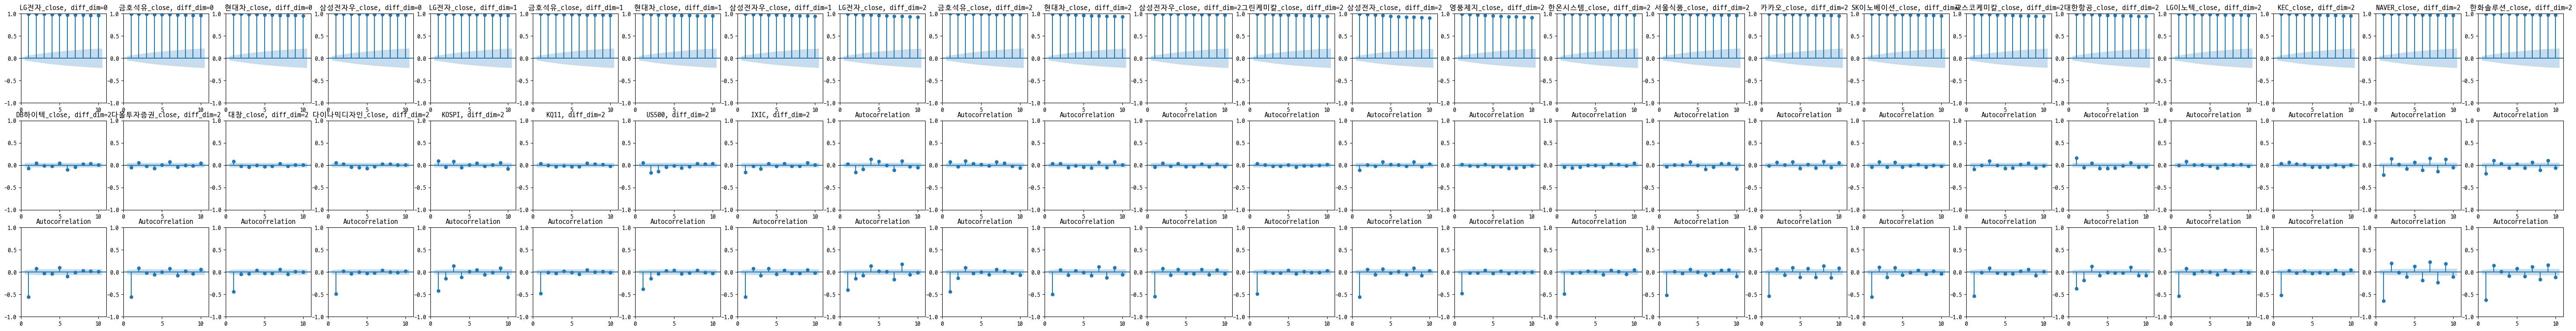

In [12]:
max_diff = 3

fig = plt.figure(figsize=(25*3,3*max_diff))
ax_list = [fig.add_subplot(max_diff,25,i+1) for i in range(25*max_diff)]

for i in range(max_diff):
    for j,V in enumerate(select_col):
        if i == 0:
            sm.graphics.tsa.plot_acf(KOSPI_var_1[V],lags=10,zero=False, ax=ax_list[25*i+j])
        elif i == 1:
            sm.graphics.tsa.plot_acf(KOSPI_var_1[V].diff().dropna(),lags=10,zero=False, ax=ax_list[25*i+j])
        else:
            sm.graphics.tsa.plot_acf(KOSPI_var_1[V].diff().diff().dropna(),lags=10,zero=False, ax=ax_list[25*i+j])
        ax_list[4*i+j].set_title(f'{V}, diff_dim={i}')

In [13]:
data_train = KOSPI_var_1[:-20].diff(periods=1).dropna()
data_test = KOSPI_var_1[-21:].diff(periods=1).dropna()
print(data_train.tail())
print('-'*20)
print(data_test.head())

      LG전자_close  금호석유_close  현대차_close  삼성전자우_close  그린케미칼_close  삼성전자_close  \
1448   -0.108432   -0.086261  -0.118745    -0.070072    -0.024086   -0.087458   
1449   -0.077451   -0.009585  -0.131939    -0.057332    -0.123443    0.000000   
1450   -0.123922   -0.038338  -0.131939    -0.121034    -0.183659   -0.062470   
1451    0.139412    0.258783   0.145133     0.299401     0.048173    0.193656   
1452    0.061961    0.009585   0.118745     0.057332     0.057205    0.087458   

      영풍제지_close  한온시스템_close  서울식품_close  카카오_close  ...  NAVER_close  \
1448    0.037649    -0.126658   -0.038475  -0.064708  ...    -0.078675   
1449    0.043924    -0.063329   -0.038475  -0.064708  ...    -0.031470   
1450   -0.225896    -0.105548   -0.192377  -0.025883  ...    -0.057695   
1451    0.131773     0.316645    0.064126   0.012942  ...     0.094410   
1452    0.150597     0.126658    0.346279   0.000000  ...     0.089165   

      한화솔루션_close  DB하이텍_close  다올투자증권_close  대창_close  다이나믹디자인_clos

In [14]:
model = VAR(data_train)

#model.select_order(30)
#results = model.fit(maxlags=30, ic='aic')

results = model.fit(3)
results.summary()

/home/clim-lab/miniconda3/envs/MEaI_transformer/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 14, Nov, 2022
Time:                     17:18:26
--------------------------------------------------------------------
No. of Equations:         25.0000    BIC:                   -135.027
Nobs:                     1449.00    HQIC:                  -139.366
Log likelihood:           53340.9    FPE:                2.25650e-62
AIC:                     -141.949    Det(Omega_mle):     6.28634e-63
--------------------------------------------------------------------
Results for equation LG전자_close
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000057         0.001892            0.030           0.976
L1.LG전자_close           -0.106986         0.030268           -3.535           0.000
L1.금호석유_close           -0.058394         0

In [15]:
#fig = results.plot_acorr()

In [16]:
lag_order = results.k_ar
fore = results.forecast(data_train.values[-results.k_ar:], 20)
pd.DataFrame(fore,columns = data_test.columns)['KOSPI'].to_numpy()


array([ 0.04490121, -0.02536995, -0.01133792, -0.01308927, -0.00326764,
       -0.0032216 , -0.0014721 ,  0.00350567,  0.00218104,  0.00227735,
        0.00190553,  0.00168445,  0.00187908,  0.00182563,  0.00180893,
        0.00180391,  0.00182956,  0.00181503,  0.00181044,  0.00181601])

In [17]:
lag_order

3

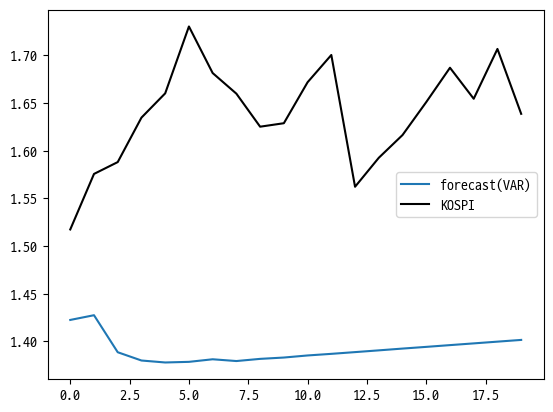

In [18]:
fore_range = 1

lag_order = results.k_ar
fore = results.forecast(data_train.values[-results.k_ar-fore_range:-fore_range], 20)
fore = pd.DataFrame(fore,columns = data_test.columns)['KOSPI'].to_numpy()

#diff 되돌리기
for i in range(len(fore)):
    past = KOSPI['KOSPI'].iloc[-20-lag_order-fore_range-1] if i==0 else fore[i-1]
    fore[i] += past

RESULT_kospi = pd.concat([pd.DataFrame(fore),KOSPI['KOSPI'][-20-fore_range:-fore_range].reset_index(drop=True)],axis=1)
RESULT_kospi.columns = ['forecast(VAR)','Real value']
plt.plot(RESULT_kospi['forecast(VAR)'],color='C0',label='forecast(VAR)')
plt.plot(RESULT_kospi['Real value'],color='Black',label='KOSPI')
plt.legend()

## Basic Transformer

In [19]:
params = {
    'window_size':30,
    'forecast_range':20,
    'num_layers':4,
    'dff':512,
    'd_model':128,
    'num_heads':4,
    'dropout':0.1
}

In [20]:
print(f'is na? {KOSPI.isna().sum().sum()}')
print('-'*80)

KOSPI_BT = KOSPI['KOSPI'].to_numpy()

print(f'length of KOSPI data : {KOSPI_BT.shape}')

split_by_window = []
label_forecast = []
for i in range(KOSPI_BT.shape[0]-params['window_size']-params['forecast_range']+1):
    split_by_window.append(KOSPI_BT[i:i+params['window_size']])
    label_forecast.append(KOSPI_BT[i+params['window_size']-1:i+params['window_size']+params['forecast_range']])
split_by_window = np.array(split_by_window)
label_forecast = np.array(label_forecast)
print(f'total process data shape(data, label) : {split_by_window.shape},{label_forecast.shape}')

is na? 0
--------------------------------------------------------------------------------
length of KOSPI data : (1473,)
total process data shape(data, label) : (1424, 30),(1424, 21)


In [21]:
# Train+Valid / Test 나누기
# Test는 끝자락 시간만, Train+valid는 섞어서
split_test_num = 3
split_point = label_forecast.shape[0]-split_test_num
shuffle_idx = np.random.choice(split_point,split_point,replace=False)

print(f'shuffling : [{shuffle_idx[0]}, {shuffle_idx[1]}, {shuffle_idx[2]} ~ {shuffle_idx[-3]}, {shuffle_idx[-2]}, {shuffle_idx[-1]}]')

test_traget = split_by_window[-split_test_num:]
test_label = label_forecast[-split_test_num:]
print(f'{test_traget.shape}{test_label.shape}')

split_by_window = split_by_window[shuffle_idx]
label_forecast = label_forecast[shuffle_idx]
print(f'{split_by_window.shape}{label_forecast.shape}')

shuffling : [1166, 903, 1345 ~ 715, 569, 1044]
(3, 30)(3, 21)
(1421, 30)(1421, 21)


In [22]:
split_point=round(label_forecast.shape[0]*0.8)
print(split_point)

BATCH_SIZE = 512
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': split_by_window[:split_point],
        'dec_inputs': label_forecast[:split_point,:-1] #teaching force
    },
    {
        'outputs': label_forecast[:split_point, 1:,np.newaxis]
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

1137


2022-11-14 17:18:26.783179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10756 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:65:00.0, compute capability: 6.1


In [23]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': split_by_window[split_point:],
        'dec_inputs': label_forecast[split_point:,:-1] #teaching force
    },
    {
        'outputs': label_forecast[split_point:, 1:,np.newaxis]  
    },
))

test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [24]:
del model_pm10

NameError: name 'model_pm10' is not defined

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


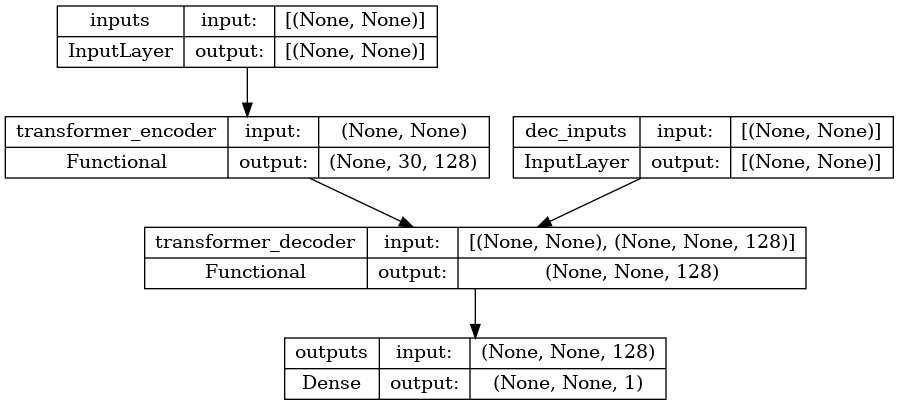

In [26]:
tf.keras.backend.clear_session()

model_kospi = basic_time_series_transformer(
    window_size=params['window_size'],
    forecast_range=params['forecast_range'],
    num_layers=params['num_layers'],
    dff=params['dff'],
    d_model=params['d_model'], 
    num_heads=params['num_heads'],
    dropout=params['dropout'],
    name="time_series_transformer")

tf.keras.utils.plot_model(model_kospi, to_file='./imgs/basic_transformer.png', show_shapes=True,show_layer_names=True)

In [27]:
model_kospi.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError()
)

callback_path = './result/basic_transformer/KOSPI'

os.makedirs(f'{callback_path}/ckpt', exist_ok=True)
ckpt_path = callback_path+'/ckpt/model_ckpt'
callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor='val_loss',
    save_best_only = True,
    save_weights_only=True,
    verbose=1
)

os.makedirs(f'{callback_path}/tsbd', exist_ok=True)
callback_tsbd = tf.keras.callbacks.TensorBoard(f'{callback_path}/tsbd')

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.75 
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [28]:
history = model_kospi.fit(train_dataset, epochs=60, validation_data=test_dataset, verbose = 1, callbacks=[callback_ckpt,callback_scheduler,callback_tsbd])

Epoch 1/60
2/3 [===================>..........] - ETA: 0s - loss: 26.4165
Epoch 1: val_loss improved from inf to 2.47639, saving model to ./result/basic_transformer/KOSPI/ckpt/model_ckpt
3/3 [==============================] - 9s 969ms/step - loss: 24.2695 - val_loss: 2.4764 - lr: 0.0010
Epoch 2/60
2/3 [===================>..........] - ETA: 0s - loss: 2.9198
Epoch 2: val_loss improved from 2.47639 to 1.83511, saving model to ./result/basic_transformer/KOSPI/ckpt/model_ckpt
3/3 [==============================] - 1s 435ms/step - loss: 2.8432 - val_loss: 1.8351 - lr: 0.0010
Epoch 3/60
2/3 [===================>..........] - ETA: 0s - loss: 1.7327
Epoch 3: val_loss improved from 1.83511 to 0.77269, saving model to ./result/basic_transformer/KOSPI/ckpt/model_ckpt
3/3 [==============================] - 1s 439ms/step - loss: 1.6698 - val_loss: 0.7727 - lr: 0.0010
Epoch 4/60
2/3 [===================>..........] - ETA: 0s - loss: 0.7520
Epoch 4: val_loss did not improve from 0.77269
3/3 [=======

In [29]:
model_kospi.load_weights('./result/basic_transformer/KOSPI/ckpt/model_ckpt')

In [30]:
fore_range = 1

data_test = KOSPI['KOSPI'].to_numpy()[np.newaxis,-(params['window_size']+params['forecast_range']+fore_range):-(params['forecast_range']+fore_range)]
data_test_dec_input = data_test[0,-1].reshape((1,1))
data_test, data_test_dec_input

(array([[1.67417589, 1.67122118, 1.70753147, 1.779596  , 1.72003026,
         1.67978139, 1.58163308, 1.60248987, 1.68972987, 1.59433407,
         1.61329709, 1.57807301, 1.55517079, 1.56087739, 1.47934399,
         1.46608757, 1.57688631, 1.65445524, 1.64862227, 1.56077629,
         1.5227997 , 1.58249181, 1.68912389, 1.64892556, 1.64124937,
         1.60584836, 1.49517599, 1.42669743, 1.24916225, 1.40245687]]),
 array([[1.40245687]]))

In [31]:
out = model_kospi.predict([data_test,data_test_dec_input])
out_ = np.concatenate([data_test_dec_input,out.reshape((1,-1))],axis=1)

for i in range(19):
    out = model_kospi.predict([data_test,out_])
    out_ = np.concatenate([data_test_dec_input,out.reshape((1,-1))],axis=1)

print(out)
print(out.shape)

1/1 [==============================] - 0s 28ms/step
[[[1.5878218]
  [1.5831206]
  [1.5792228]
  [1.582141 ]
  [1.5941937]
  [1.580647 ]
  [1.5812255]
  [1.5964566]
  [1.5927105]
  [1.591741 ]
  [1.5911852]
  [1.5840789]
  [1.5921289]
  [1.5986518]
  [1.6005558]
  [1.5901912]
  [1.5864466]
  [1.6004151]
  [1.586755 ]
  [1.5831565]]]
(1, 20, 1)


In [48]:
RESULT_kospi_2 = pd.concat([pd.DataFrame(out[0,:,:]),RESULT_kospi],axis=1)
RESULT_kospi_2.columns = ['forecast(Basic Transformer)','forecast(VAR)','Real value']

RESULT_kospi_2 = RESULT_kospi_2*np.sqrt(scaler_kospi.var_[0])+scaler_kospi.mean_[0] #scale 되돌림

RESULT_kospi_2.to_csv('./비교모델 결과(KOSPI).csv',index=False)

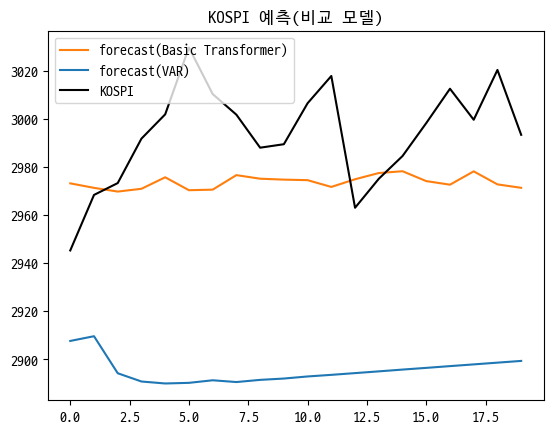

In [49]:
plt.plot(RESULT_kospi_2['forecast(Basic Transformer)'],color='C1',label='forecast(Basic Transformer)')
plt.plot(RESULT_kospi_2['forecast(VAR)'],color='C0',label='forecast(VAR)')
plt.plot(RESULT_kospi_2['Real value'],color='Black',label='KOSPI')
plt.title('KOSPI 예측(비교 모델)')
plt.legend()

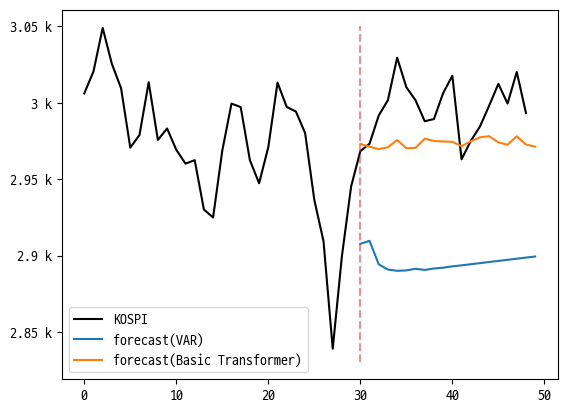

In [58]:
from matplotlib import ticker
K = KOSPI['KOSPI'].iloc[-50:-1].reset_index(drop=True).copy()
K = K*np.sqrt(scaler_kospi.var_[0])+scaler_kospi.mean_[0]

fig, ax = plt.subplots(1,1)
ax.plot(K,color='black',label='KOSPI')
ax.plot([i for i in range(30,50)],RESULT_kospi_2['forecast(VAR)'],color='C0',label='forecast(VAR)')
ax.plot([i for i in range(30,50)],RESULT_kospi_2['forecast(Basic Transformer)'],color='C1',label='forecast(Basic Transformer)')
ax.vlines(30,2830,3050,linestyles='dashed',color='C3',alpha=0.5)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.legend()

https://wikidocs.net/31379